# Correcting the Fitting Parameters in Table 1 of CR21

In Cimerman and Rafikov 2021, the fitting parameters to $\Delta \chi$ were incorrectly estimated due to a scaling error of $2 \pi$ in the calculation of $\partial F/\partial R$. We have confirmed that rescaling their solution by $2 \pi$ gives surface density estimates as expected (see `Example.ipynb`) and in this notebook we now re-estimate the ftting paramters.

We take the 'known' correct solution of 

\begin{equation}
    f_{dep} = 2 \pi f_{\text{as written}}
\end{equation}

and use this to calculate a corrected $\Delta \chi$ and then fit a new set of the parameters $A, \tau_b, \alpha_1, \alpha_2 \text{and} \Delta$ using this.

In [12]:
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar, curve_fit

import matplotlib.pyplot as plt

from gap_shape_python.calc_shock import *

In [13]:

def create_minimizer(p_orig):
    def func(epsilon):
        psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))
        return np.abs(p_orig - psi)
    return func

def get_epsilon(psi):
    return minimize_scalar(create_minimizer(psi), bracket=[-1e-5, 1], method='brent').x


def create_corrected_fit(p, h_p, m_p, correction=2 * np.pi):
    R = np.linspace(0.1, 5, 1000)

    tau = compute_tau_R_keplerian(R, p, h_p, m_p)

    tau_0 = 1.89 * m_p  # equation 16 in CR21
    
    def chi_func(tau, A, tau_b, alpha_1, alpha_2, delta):
        tau_squiggle = np.abs(tau - tau_0)

        return (A * (tau_squiggle/tau_b)**(-1 * alpha_1) *
                 (1 + (tau_squiggle/tau_b)**(1/delta))**(
                    (alpha_1 - alpha_2)*delta))

    
    delta_chi = compute_delta_chi(R, tau, tau_0, use_cr_21=True)
            
    epsilon_original = delta_chi * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)

    psi_original = (epsilon_original * (2 + epsilon_original) - 2 * (1 + epsilon_original) * np.log(1 + epsilon_original))/(2 * (1 + epsilon_original))

    v_get_epsilon = np.vectorize(get_epsilon)

    new_epsilon_scaled = v_get_epsilon(psi_original * correction)

    delta_chi_new = new_epsilon_scaled/(m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2))

    inner_tau = tau[R < 1]
    inner_chi = delta_chi_new[R < 1][inner_tau > tau_0]
    inner_tau = inner_tau[inner_tau > tau_0]

    outer_tau = tau[R > 1]
    outer_chi = delta_chi_new[R > 1][outer_tau > tau_0]
    outer_tau = outer_tau[outer_tau > tau_0]
    
    # Refit Table 1 values based on this

    # [2.07, 0.300, -10.84, 0.505, 0.623]
    popt_inner, pcov = curve_fit(chi_func, inner_tau, inner_chi,
                           # Use the CR21 fit as input
                            p0 = [2.07, 0.300, -10.84, 0.505, 0.623])
    print('inner', popt_inner)
    print(np.diagonal(pcov)**(1/2))

    popt_outer, pcov = curve_fit(chi_func, outer_tau, outer_chi,
                           # Use the CR21 fit as input
                            p0 = [3.11, 0.181, -8.63, 0.525, 0.766])
    print('outer', popt_outer)
    print(np.diagonal(pcov)**(1/2))
    # Recalculate everything based on these values to compare
    
    alternative_fit = {'inner': popt_inner, 'outer': popt_outer}
    
    delta_chi = compute_delta_chi(R, tau, tau_0, False, alternative_fit)

    epsilon = delta_chi * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)
    
    psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))

    
    plt.plot(R, psi_original * correction)
    plt.plot(R, psi)
    
    return alternative_fit


inner [ 3.64447063  0.41486091 -7.75264931  0.51830383  0.59109359]
[0.02656137 0.00523432 0.11843553 0.00024359 0.00144816]
outer [ 4.99262939  0.29350545 -5.74964165  0.53780626  0.70719867]
[0.02240955 0.00224105 0.04446242 0.00010212 0.0009444 ]


/tmp/ipykernel_1658/2863837612.py:3: RuntimeWarning: invalid value encountered in log
  psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))


{'inner': array([ 3.64447063,  0.41486091, -7.75264931,  0.51830383,  0.59109359]),
 'outer': array([ 4.99262939,  0.29350545, -5.74964165,  0.53780626,  0.70719867])}

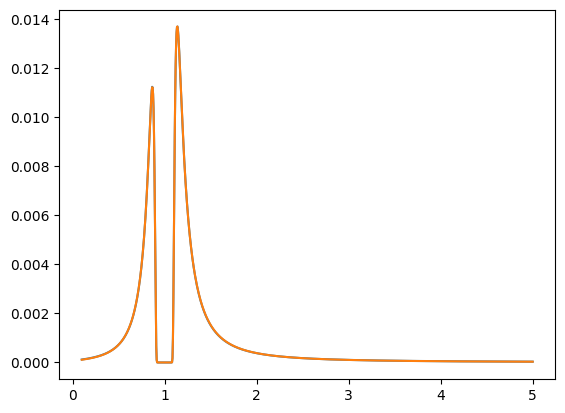

In [14]:
create_corrected_fit(1.5, 0.05, 0.25)